# 酒店評論數據 : 情感性分析
* 數據來源  : https://github.com/SophonPlus/ChineseNlpCorpus/blob/master/datasets/ChnSentiCorp_htl_all/intro.ipynb

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf

from sklearn.utils import shuffle
from train import IMetric, TrainBase
from tensorflow.keras.utils import to_categorical
from processor import DataLoader
from transformers import BertTokenizer
from tqdm import tqdm

In [2]:
data = pd.read_csv('data/sensitive.csv')
data = data.rename(columns={'review': 'content'})
data = data.dropna(0).reset_index(drop=True)
# shuffle the data
data = shuffle(data)
data.head(10)

,label,content
1150,1,"2008.4.5入住该酒店南楼大床间,总体感觉不错，符合三星标准。值得赞一下的是客房送餐很好..."
622,1,房间还算可以，就是旧了些。早餐没有酸奶，有些美中不足。
2720,1,很好的酒店，设施和服务都让人满意，就是偏远了一点。
5689,0,不如新开张时候好了，房间的地毯比较脏，网速是很慢的，电视的操作也非常不人性化。淋浴的地漏下水...
4758,1,我们是从银滩的酒店住宿后，搬过来的，所以这个酒店虽然离银滩远点，但是也没觉得什么不便，每天去...
2312,1,周围的环境很好.在房间可以看到大海.普通间很一般.建议住豪华间.价格差不了多少.豪华间非常大...
5402,0,一句话，那是相当的差！这也叫3星，有没有搞错，旅馆水平都没有。大厅倒过得去。房间里面消毒水的...
2336,1,这里虽然房间不大，但是充满温馨；虽然设施不很豪华，但是比较干净；虽然服务人员不多，但是比较细...
3758,1,上个周末又去了河源。这回提前预订了万豪国际酒店2个晚上，酒店真的没有令我们夫妇失望，我们为自...
1868,1,"房间的整洁及服务都不错,人员的训练及接待都很亲切,入住的感觉也很不错"


## 去空值

In [5]:
print(data.info())
print('=' * 30)
data.content.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7765 entries, 1150 to 2585
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    7765 non-null   int64 
 1   content  7765 non-null   object
dtypes: int64(1), object(1)
memory usage: 182.0+ KB
None


0

## * 去除重複標點符號，例如:"你好!!!!!" --> "你好!"
## * 去除跳脫字符與網址

In [6]:
def preprocess_data(context):
    import re
    import numpy
    context = context.strip()
    context = re.sub(r'[\s]+|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))', "", context)
    context = re.sub(r'([?。,!])\1+', "", context)
    
    return context

data['content'] = data['content'].apply(preprocess_data)

### 正負樣本比例

      label
1  0.685383
0  0.314617


<AxesSubplot:>

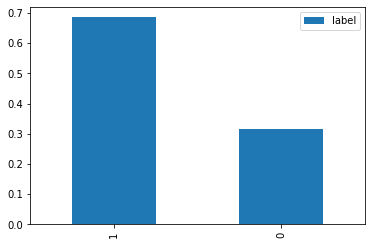

In [7]:
value_count = pd.DataFrame(data.label.value_counts(normalize=True))
print(value_count)
print('=' * 20)
value_count.plot.bar()

### 字數統計

<AxesSubplot:title={'center':'neg'}, ylabel='Frequency'>

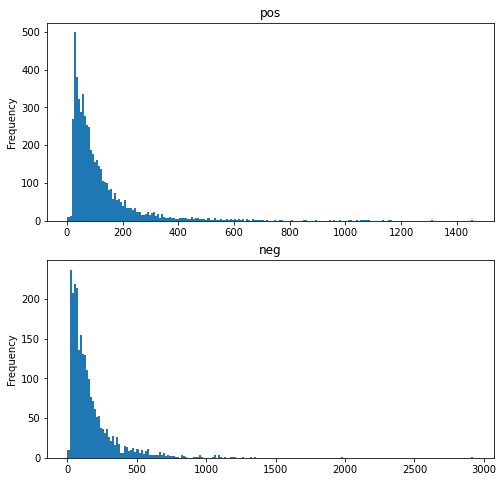

In [8]:
pos_len = data[data.label == 1].content.apply(len)
neg_len = data[data.label == 0].content.apply(len)
pos_len.name, neg_len.name = 'pos_content', 'neg_content'
fig, axs = plt.subplots(2, figsize=(8,8))

pos_len.plot.hist(ax=axs[0], title='pos',bins=200)
neg_len.plot.hist(ax=axs[1], title='neg', bins=200)

In [9]:
pd.concat([pos_len.describe(), neg_len.describe()], 1)

,pos_content,neg_content
count,5322.000000,2443.000000
mean,111.867531,163.998363
std,119.109333,180.723843
min,2.000000,2.000000
25%,42.000000,57.000000
50%,75.000000,108.000000
75%,135.750000,201.000000
max,1459.000000,2924.000000


In [10]:
count = 200
print(f'正向文字小於{count}字的比例 : ',  len(pos_len[pos_len <= count]) / len(pos_len))
print(f'負向文字小於{count}字的比例 : ',  len(neg_len[neg_len <= count]) / len(neg_len))

正向文字小於200字的比例 :  0.8703494926719278
負向文字小於200字的比例 :  0.7490790012279983


## Split data into train and test

In [11]:
split_point = int(len(data) * 0.8)
train_data = data.iloc[:split_point]
test_data = data.iloc[split_point:]
train_data.to_pickle('./data/train_data/train.pickle')
test_data.to_pickle('./data/test_data/test.pickle')

In [12]:
train_data

,label,content
1150,1,"2008.4.5入住该酒店南楼大床间,总体感觉不错，符合三星标准。值得赞一下的是客房送餐很好..."
622,1,房间还算可以，就是旧了些。早餐没有酸奶，有些美中不足。
2720,1,很好的酒店，设施和服务都让人满意，就是偏远了一点。
5689,0,不如新开张时候好了，房间的地毯比较脏，网速是很慢的，电视的操作也非常不人性化。淋浴的地漏下水...
4758,1,我们是从银滩的酒店住宿后，搬过来的，所以这个酒店虽然离银滩远点，但是也没觉得什么不便，每天去...
...,...,...
5029,1,位置好是没得说的，酒店比较老旧了，宽带有的还要收费。
5779,0,千万不要住！首先是走廊和房间都一股发霉的味道！而且早餐超级难吃！最受不了的就是招待所级别的服...
2848,1,房间很一般，但服务员态度还不错。不过听说韶山还有比这个更好的酒店，但携程没有。免费注册网站导...
3767,1,免费自助早餐在该酒店斜对面的阳光.和酒巴.这个酒巴可是被用来拍过电影的哦.


#  Basic Train
* 用roberta model 建模

In [6]:
from train import IMetric, TrainBase

from roberta.model import RoBertaFineTune

## Prepare training data

In [3]:
training_data = pd.read_pickle('./data/train_data/train.pickle')
split_spot = int(training_data.shape[0] * 0.8)
train = training_data.iloc[: split_spot]
validation = training_data.iloc[split_spot: ]

tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")
train_BTL = DataLoader(data=train,
                      MAX_SEQUENCE_LENGTH=200,
                      batch_size=10,
                      imbalance_sample=False,
                      tokenizer=tokenizer)

val_BTL = DataLoader(data=validation, 
                     MAX_SEQUENCE_LENGTH=200,
                     batch_size=10, 
                     imbalance_sample=False,
                     tokenizer=tokenizer)

In [4]:
model = RoBertaFineTune(False)


# Define customized metrics

In [3]:
class Metrics(IMetric):

    def __init__(self):
        self.f1 = tfa.metrics.F1Score(num_classes=2, name='f1_score')
        self.acc_metric = tf.keras.metrics.CategoricalAccuracy()
        self.AUC = tf.keras.metrics.AUC()
        self.recall_neg = tf.keras.metrics.Recall(class_id=0)
        

    def calculate_metric(self, y_batch, logits):
        self.f1(to_categorical(y_batch, 2), logits)
        self.AUC(to_categorical(y_batch, 2), logits)
        self.acc_metric(to_categorical(y_batch, 2), logits)
        self.recall_neg(to_categorical(y_batch, 2), logits)
        
        
    @property
    def get_result(self):
        result = dict()
        for name, metric in self.__dict__.items():
            result_metric =  metric.result()
            
            try:
                #get the f1 score of label=1 
                result[name] = result_metric[1]
            except:
                
                result[name] = result_metric
           
                

        return result
        

In [6]:
class RegularTrain(TrainBase):
    def __init__(self, model, metric: Metrics):
        self.model = model
        self.metric = metric

    def train_step(self, X_batch, y_batch, optimizer, loss_recoder):
        with tf.GradientTape() as tape:
            logits = self.model(X_batch)

            loss_value = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_batch, logits)

            loss_recoder.append(loss_value.numpy())

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        return logits, loss_recoder

    def setting_optimizer(self, decay_steps):
        bert_lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[200, 600, 1200], 
                                                                                values=[2e-5, 1.5e-5, 1.5e-5*0.5, 1.5e-5*0.25])

        optimizer = tf.keras.optimizers.Adam(learning_rate=bert_lr_schedule)
        
        
        return optimizer


In [7]:
RegularTrain(model=model, metric=Metrics).start_to_train(train_data_loader=train_BTL, 
                                                         epochs=10,
                                                         checkpoint_path='./roberta/roberta_checkpoint_v3',
                                                         tensorboard_path={'train':f'./roberta/tensorboard/train_roberta_v3', 'validation': f'./roberta/tensorboard/val_roberta_v3'},
                                                         validation_data_loader=val_BTL)

  0%|          | 0/497 [00:00<?, ?it/s]

tf.Tensor(2e-05, shape=(), dtype=float32)
EPOCH 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When fi

100%|██████████| 497/497 [02:27<00:00,  3.37it/s]


training loss is 0.28685104499910197
Training f1 over epoch : 0.9099469780921936
Training acc_metric over epoch : 0.876836359500885
Training AUC over epoch : 0.9496009945869446
Training recall_neg over epoch : 0.7976040244102478


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.42799498462677
Validation f1 over epoch : 0.9335548281669617
Validation acc_metric over epoch : 0.903459370136261
Validation AUC over epoch : 0.966552197933197
Validation recall_neg over epoch : 0.7486631274223328
tf.Tensor(1.5e-05, shape=(), dtype=float32)
EPOCH 1


100%|██████████| 497/497 [02:20<00:00,  3.53it/s]


training loss is 0.1246123099170243
Training f1 over epoch : 0.9656499624252319
Training acc_metric over epoch : 0.9533105492591858
Training AUC over epoch : 0.9902324080467224
Training recall_neg over epoch : 0.9306431412696838


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4087435846328735
Validation f1 over epoch : 0.9299362897872925
Validation acc_metric over epoch : 0.9026548862457275
Validation AUC over epoch : 0.9621875882148743
Validation recall_neg over epoch : 0.8529411554336548
tf.Tensor(7.5e-06, shape=(), dtype=float32)
EPOCH 2


100%|██████████| 497/497 [02:21<00:00,  3.51it/s]


training loss is 0.050926236096597174
Training f1 over epoch : 0.9887408018112183
Training acc_metric over epoch : 0.9847051501274109
Training AUC over epoch : 0.998123049736023
Training recall_neg over epoch : 0.9810844659805298


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.40875198888778685
Validation f1 over epoch : 0.9326655268669128
Validation acc_metric over epoch : 0.9026548862457275
Validation AUC over epoch : 0.9495038986206055
Validation recall_neg over epoch : 0.759358286857605
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 3


100%|██████████| 497/497 [02:21<00:00,  3.51it/s]


training loss is 0.014082147898171209
Training f1 over epoch : 0.9977807402610779
Training acc_metric over epoch : 0.9969812631607056
Training AUC over epoch : 0.9996352791786194
Training recall_neg over epoch : 0.9974779486656189


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4119042065143585
Validation f1 over epoch : 0.927823007106781
Validation acc_metric over epoch : 0.9002413749694824
Validation AUC over epoch : 0.9508109092712402
Validation recall_neg over epoch : 0.8609625697135925
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 4


100%|██████████| 497/497 [02:21<00:00,  3.51it/s]


training loss is 0.00686092549843397
Training f1 over epoch : 0.9989650249481201
Training acc_metric over epoch : 0.9985912442207336
Training AUC over epoch : 0.9997433423995972
Training recall_neg over epoch : 0.9987389445304871


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4091466705799103
Validation f1 over epoch : 0.9307384490966797
Validation acc_metric over epoch : 0.9026548862457275
Validation AUC over epoch : 0.9454852342605591
Validation recall_neg over epoch : 0.8262032270431519
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 5


100%|██████████| 497/497 [02:21<00:00,  3.50it/s]


training loss is 0.0030090797013867603
Training f1 over epoch : 0.9995565414428711
Training acc_metric over epoch : 0.9993962645530701
Training AUC over epoch : 0.9999926686286926
Training recall_neg over epoch : 0.9993695020675659


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4113434855937958
Validation f1 over epoch : 0.9283667802810669
Validation acc_metric over epoch : 0.8994368314743042
Validation AUC over epoch : 0.9379585981369019
Validation recall_neg over epoch : 0.8235294222831726
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 6


100%|██████████| 497/497 [02:21<00:00,  3.50it/s]


training loss is 0.0010386931244137517
Training f1 over epoch : 0.9998522400856018
Training acc_metric over epoch : 0.9997987747192383
Training AUC over epoch : 0.9999999403953552
Training recall_neg over epoch : 1.0


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4110321269035339
Validation f1 over epoch : 0.9307384490966797
Validation acc_metric over epoch : 0.9026548862457275
Validation AUC over epoch : 0.9318493008613586
Validation recall_neg over epoch : 0.8262032270431519
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 7


100%|██████████| 497/497 [02:25<00:00,  3.41it/s]


training loss is 0.0003135131503638279
Training f1 over epoch : 1.0
Training acc_metric over epoch : 1.0
Training AUC over epoch : 1.0
Training recall_neg over epoch : 1.0


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.41134078073501584
Validation f1 over epoch : 0.9307384490966797
Validation acc_metric over epoch : 0.9026548862457275
Validation AUC over epoch : 0.9256030321121216
Validation recall_neg over epoch : 0.8262032270431519
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 8


100%|██████████| 497/497 [02:25<00:00,  3.40it/s]


training loss is 0.00019250114405210556
Training f1 over epoch : 1.0
Training acc_metric over epoch : 1.0
Training AUC over epoch : 0.9999999403953552
Training recall_neg over epoch : 1.0


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.41167004251480105
Validation f1 over epoch : 0.9295936226844788
Validation acc_metric over epoch : 0.9010458588600159
Validation AUC over epoch : 0.9239202737808228
Validation recall_neg over epoch : 0.8235294222831726
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 9


100%|██████████| 497/497 [02:27<00:00,  3.37it/s]


training loss is 0.00012974987546170798
Training f1 over epoch : 1.0
Training acc_metric over epoch : 1.0
Training AUC over epoch : 1.0
Training recall_neg over epoch : 1.0
 loss of validation is 0.41203864884376523
Validation f1 over epoch : 0.9295936226844788
Validation acc_metric over epoch : 0.9010458588600159
Validation AUC over epoch : 0.9228205680847168
Validation recall_neg over epoch : 0.8235294222831726


# Google papper Train

### data agument --> back translate

### Prepare training data

In [4]:
training_data = pd.read_pickle('./data/train_data/train.pickle')
split_spot = int(training_data.shape[0] * 0.8)
train = training_data.iloc[: split_spot]
validation = training_data.iloc[split_spot: ]

back_translate_data = pd.read_pickle('./data/augment_data/back_translate_data.pkl').iloc[: split_spot]
back_translate_data_train = pd.DataFrame(back_translate_data['back_translate']).rename(columns={'back_translate':'content'})

In [7]:
back_translate_data

,content,back_translate
0,"2008.4.5入住该酒店南楼大床间,总体感觉不错，符合三星标准。值得赞一下的是客房送餐很好...",2008.4.5从南汇大号床房间开始，整体感觉很好，符合三星标准。房间很好，食物很好，价格不...
1,房间还算可以，就是旧了些。早餐没有酸奶，有些美中不足。,房间仍然可以，它很老。早餐没有酸奶，美丽有一点。
2,很好的酒店，设施和服务都让人满意，就是偏远了一点。,非常好的酒店，设施和服务很满意，它很远。
3,不如新开张时候好了，房间的地毯比较脏，网速是很慢的，电视的操作也非常不人性化。淋浴的地漏下水...,有一个新的开口更好，房间的地毯更脏，速度很慢，电视的运作非常稳定。淋浴的地板流失很慢，你将不...
4,我们是从银滩的酒店住宿后，搬过来的，所以这个酒店虽然离银滩远点，但是也没觉得什么不便，每天去...,在宾坦的酒店住宿后，我们搬家了，所以这家酒店虽然这家酒店离Yintan很远，但它并不是任何不...
...,...,...
4964,"两个月里面已经住了三次了,当然好啦,交通也很方便哈",它已经在两个月内生活了三次。当然，交通也很方便。
4965,"物有所值,但其预定车票的服务太一般,我给他们商务中心要求订次日到西安的卧铺票,除要收我30元...",有钱，但预订机票的服务太一般，我会问他们的商业中心订购睡眠机票到西安，除了收集我30元的门票...
4966,入住的酒店设施有点老，电视机也不较小，跟500元的房价还是有点差距的，不过服务不错，当天还送...,酒店的设施有点老，电视不小，价格500元仍然有点差距，但服务很好，生日鲜花和水果已被发送。
4967,房间小得不像话，早餐差得不像话，绝对不会再光顾。隔壁的南国大酒店看上去不错。晚上想在酒店的餐...,房间不喜欢，早餐是不可移开的，它永远不会再次光顾。南中国宾馆隔壁看起来很好。我想在酒店的餐厅...


In [8]:

tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")
train_BTL = DataLoader(data=train,
                      MAX_SEQUENCE_LENGTH=200,
                      batch_size=10,
                      imbalance_sample=False,
                      tokenizer=tokenizer)

val_BTL = DataLoader(data=validation, 
                     MAX_SEQUENCE_LENGTH=200,
                     batch_size=10, 
                     imbalance_sample=False,
                     tokenizer=tokenizer)

back_translate_BTL = DataLoader(data=back_translate_data_train, 
                     MAX_SEQUENCE_LENGTH=200,
                     batch_size=10, 
                     imbalance_sample=False,
                     tokenizer=tokenizer,
                     mode='no label')

### Overriding the 'start_to_train' method

In [9]:
import math
from tqdm import tqdm
from train import TensorBoard
class BackTranslationTrain(TrainBase):
    def __init__(self, model, metric: Metrics):
        self.model = model
        self.metric = metric
        self.back_translation_yielder = None
        
    def train_step(self, X_batch, y_batch, optimizer, loss_recoder):
        with tf.GradientTape() as tape:
            logits = self.model(X_batch)
            data_batch = next(iter(self.back_translation_yielder))
            back_translate_x_batch = data_batch[0:3]
#             print( back_translate_x_batch)

            crossentropy_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_batch, logits)
            kl_loss = self._calculate_KLDivergence_loss_for_back_translation(X_batch_logits=logits, back_translate_x_batch=back_translate_x_batch)
            
            _lambda = 1 
            loss_value = crossentropy_loss + (_lambda * kl_loss)

            loss_recoder.append(loss_value.numpy())

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        return logits, loss_recoder
    
    def setting_optimizer(self, decay_steps):
        bert_lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[200, 600, 1200], 
                                                                                values=[2e-5, 1.5e-5, 1.5e-5*0.5, 1.5e-5*0.25])


        optimizer = tf.keras.optimizers.Adam(learning_rate=bert_lr_schedule)
        return optimizer
    
    
    def start_to_train(self, train_data_loader,
                   epochs,
                   checkpoint_path,
                   tensorboard_path: dict,
                   back_translation_data_loader,
                   validation_data_loader=None,
                   ):

        BATCH_LENGHT = math.ceil(train_data_loader.data.shape[0] / train_data_loader.batch_size)

        # saving manager
        checkpoint = tf.train.Checkpoint(Model=self.model)
        #         manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_path, max_to_keep=10)

        # Initialize Metric
        TrainMetric = self.metric()

        writer = tf.summary.create_file_writer(tensorboard_path['train'])

        optimizer = self.setting_optimizer(decay_steps=epochs)
        for epoch in range(epochs):
            print(optimizer.lr(optimizer.iterations))
            print('==========================')
            print(f'EPOCH {epoch}')
            print('==========================')

            loss_recoder = []

            #             tf.summary.trace_on(graph=True)
            self.back_translation_yielder = self._yield_back_translation_btl(back_translation_data_loader)
            for step, (X_batch_train, y_batch_train) in tqdm(enumerate(train_data_loader), total=BATCH_LENGHT):
                logits, loss_recoder = self.train_step(X_batch=X_batch_train,
                                                       y_batch=y_batch_train,
                                                       optimizer=optimizer,
                                                       loss_recoder=loss_recoder)

                TrainMetric.calculate_metric(y_batch_train, logits=logits)
                if step % 500 == 0:
                    #                     manager.save(checkpoint_number=step)
                    checkpoint.save(f'{checkpoint_path}/ckpt-epoch:{epoch}')

            epoch_loss = sum(loss_recoder) / len(loss_recoder)

            print(f"training loss is {epoch_loss}")

            for name, result in TrainMetric.get_result.items():
                print(f'Training {name} over epoch : {float(result)}')
            print('============================================================')

            #             with writer.as_default():
            #                 tf.summary.trace_export(name="my_trace",step=0)

            TrainTB = TensorBoard(writer=writer,
                                  model=self.model)
            TrainTB.start_to_write(metrics_result=TrainMetric.get_result,
                                   step=epoch,
                                   loss=epoch_loss,
                                   histogram=True,
                                   optimizer=optimizer)

            TrainMetric.reset()

            if validation_data_loader is not None:
                self._validation(validation_data_loader=validation_data_loader,
                                 val_logdir=tensorboard_path['validation'],
                                 ep=epoch)

    
    
    def _yield_back_translation_btl(self, back_translation_data: DataLoader): 
        yield from back_translation_data
        
    def _calculate_KLDivergence_loss_for_back_translation(self, X_batch_logits, back_translate_x_batch):
        back_translate_x_logits = self.model(back_translate_x_batch)
        kl_loss = tf.keras.losses.KLDivergence()(X_batch_logits, back_translate_x_logits)
        return kl_loss

In [10]:
model = RoBertaFineTune(False)


In [11]:
BackTranslationTrain(model=model, metric=Metrics).start_to_train(train_data_loader=train_BTL, 
                                                                 epochs=10,
                                                                 checkpoint_path='./roberta/back_translate_roberta_checkpoint_v3',
                                                                 tensorboard_path={'train':f'./roberta/tensorboard/back_translate_train_roberta_v3', 'validation': f'./roberta/tensorboard/back_translate_val_roberta_v3'},
                                                                 validation_data_loader=val_BTL, 
                                                                 back_translation_data_loader=back_translate_BTL)

  0%|          | 0/497 [00:00<?, ?it/s]

tf.Tensor(2e-05, shape=(), dtype=float32)
EPOCH 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When fi

100%|██████████| 497/497 [04:24<00:00,  1.88it/s]


training loss is 0.31330701283046175
Training f1 over epoch : 0.9137780666351318
Training acc_metric over epoch : 0.8808613419532776
Training AUC over epoch : 0.9550256729125977
Training recall_neg over epoch : 0.7818410992622375


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.43640807914733887
Validation f1 over epoch : 0.9238302111625671
Validation acc_metric over epoch : 0.8873692750930786
Validation AUC over epoch : 0.9634450674057007
Validation recall_neg over epoch : 0.6791443824768066
tf.Tensor(1.5e-05, shape=(), dtype=float32)
EPOCH 1


100%|██████████| 497/497 [04:17<00:00,  1.93it/s]


training loss is 0.1713484374082964
Training f1 over epoch : 0.9645599126815796
Training acc_metric over epoch : 0.9517005681991577
Training AUC over epoch : 0.9899201989173889
Training recall_neg over epoch : 0.9224464297294617


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4041449258327484
Validation f1 over epoch : 0.9381443858146667
Validation acc_metric over epoch : 0.9131134152412415
Validation AUC over epoch : 0.9727451801300049
Validation recall_neg over epoch : 0.8449198007583618
tf.Tensor(7.5e-06, shape=(), dtype=float32)
EPOCH 2


100%|██████████| 497/497 [04:17<00:00,  1.93it/s]


training loss is 0.09792406513248861
Training f1 over epoch : 0.9834221005439758
Training acc_metric over epoch : 0.9774602651596069
Training AUC over epoch : 0.9974770545959473
Training recall_neg over epoch : 0.9678436517715454


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.39937058281898496
Validation f1 over epoch : 0.9399656653404236
Validation acc_metric over epoch : 0.9155269265174866
Validation AUC over epoch : 0.9711090326309204
Validation recall_neg over epoch : 0.8449198007583618
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 3


100%|██████████| 497/497 [04:20<00:00,  1.91it/s]


training loss is 0.05729922820215246
Training f1 over epoch : 0.9920213222503662
Training acc_metric over epoch : 0.9891326427459717
Training AUC over epoch : 0.9991122484207153
Training recall_neg over epoch : 0.9823455214500427


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.39723227167129516
Validation f1 over epoch : 0.9362688660621643
Validation acc_metric over epoch : 0.9115044474601746
Validation AUC over epoch : 0.9671357870101929
Validation recall_neg over epoch : 0.8689839839935303
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 4


100%|██████████| 497/497 [04:20<00:00,  1.90it/s]


training loss is 0.03545338292423471
Training f1 over epoch : 0.9955608248710632
Training acc_metric over epoch : 0.9939625859260559
Training AUC over epoch : 0.9993152618408203
Training recall_neg over epoch : 0.993064284324646


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4000521020889282
Validation f1 over epoch : 0.936896026134491
Validation acc_metric over epoch : 0.9106999039649963
Validation AUC over epoch : 0.9603378176689148
Validation recall_neg over epoch : 0.8235294222831726
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 5


100%|██████████| 497/497 [04:21<00:00,  1.90it/s]


training loss is 0.02684514303127176
Training f1 over epoch : 0.997633159160614
Training acc_metric over epoch : 0.9967800378799438
Training AUC over epoch : 0.999362587928772
Training recall_neg over epoch : 0.99684739112854


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4044620838165283
Validation f1 over epoch : 0.9329608678817749
Validation acc_metric over epoch : 0.903459370136261
Validation AUC over epoch : 0.9522846341133118
Validation recall_neg over epoch : 0.7700534462928772
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 6


100%|██████████| 497/497 [04:21<00:00,  1.90it/s]


training loss is 0.015559593322045043
Training f1 over epoch : 0.9983725547790527
Training acc_metric over epoch : 0.997786283493042
Training AUC over epoch : 0.9994890689849854
Training recall_neg over epoch : 0.9987389445304871


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.39713256096839905
Validation f1 over epoch : 0.9396502375602722
Validation acc_metric over epoch : 0.9139179587364197
Validation AUC over epoch : 0.9523666501045227
Validation recall_neg over epoch : 0.8101603984832764
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 7


100%|██████████| 497/497 [04:21<00:00,  1.90it/s]


training loss is 0.01704380734049728
Training f1 over epoch : 0.9982243180274963
Training acc_metric over epoch : 0.9975849986076355
Training AUC over epoch : 0.9993069171905518
Training recall_neg over epoch : 0.9987389445304871


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4024661900997162
Validation f1 over epoch : 0.9330199360847473
Validation acc_metric over epoch : 0.9082863926887512
Validation AUC over epoch : 0.9539939761161804
Validation recall_neg over epoch : 0.8957219123840332
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 8


100%|██████████| 497/497 [04:23<00:00,  1.89it/s]


training loss is 0.01763424325224445
Training f1 over epoch : 0.9983730316162109
Training acc_metric over epoch : 0.997786283493042
Training AUC over epoch : 0.9994682669639587
Training recall_neg over epoch : 0.998108446598053


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.3976629776954651
Validation f1 over epoch : 0.939150333404541
Validation acc_metric over epoch : 0.9147224426269531
Validation AUC over epoch : 0.9572155475616455
Validation recall_neg over epoch : 0.8529411554336548
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 9


100%|██████████| 497/497 [04:23<00:00,  1.88it/s]


training loss is 0.010047289896257488
Training f1 over epoch : 0.9989650249481201
Training acc_metric over epoch : 0.9985912442207336
Training AUC over epoch : 0.9997690916061401
Training recall_neg over epoch : 0.9987389445304871
 loss of validation is 0.3977262268066406
Validation f1 over epoch : 0.93746417760849
Validation acc_metric over epoch : 0.912308931350708
Validation AUC over epoch : 0.952040433883667
Validation recall_neg over epoch : 0.8475936055183411


## Testing

In [2]:
import numpy as np
from time import time
from sklearn.metrics import classification_report


In [3]:
tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")

test = pd.read_pickle('./data/test_data/test.pickle')

In [4]:
def calcuate_test_loss(y_pred_logitis, y_true):
#     y_true = [y_true.map({'negative':1, 'positive':0}).iloc[0]]
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred_logitis)
    return loss

def predict(model, test_data):
    y_pred_li, y_pred_logitis_li, pooler_out_li = [], [], []
    predict_loss = []
    for i in range(0, len(test_data), 1):
        data = test_data.iloc[i : i + 1]

        pred_BTL = DataLoader(data=data ,
                         MAX_SEQUENCE_LENGTH=200,
                         batch_size=len(data), 
                         imbalance_sample=False,
                         tokenizer=tokenizer)

        y_pred, y_pred_logitis, pooler_out  = model.predict(pred_BTL, model=model, return_logistis_and_pooler=True)
        predict_loss.append(calcuate_test_loss(y_pred_logitis, test_data.iloc[i : i + 1]['label']))
        y_pred_li.extend(list(y_pred.numpy()))
        y_pred_logitis_li.extend(list(y_pred_logitis.numpy().max(-1)))
        pooler_out_li.append(pooler_out.numpy())
    return y_pred_li, y_pred_logitis_li, pooler_out_li, predict_loss
    
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## General roberta

In [7]:
%%time
general_roberta = RoBertaFineTune(False).load_model('./roberta/roberta_checkpoint_v3/', latest=True)
y_pred_li, y_pred_logitis_li, pooler_out_li, predict_loss = predict(general_roberta, test)

.....model is loading
You got it
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

### predict loss

<AxesSubplot:ylabel='Frequency'>

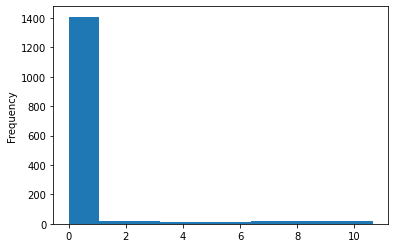

In [8]:
pd.Series([i.numpy() for i in predict_loss]).plot(kind='hist')


              precision    recall  f1-score   support

         neg       0.83      0.88      0.85       483
         pos       0.94      0.92      0.93      1070

    accuracy                           0.91      1553
   macro avg       0.89      0.90      0.89      1553
weighted avg       0.91      0.91      0.91      1553

Confusion matrix, without normalization
[[423  60]
 [ 85 985]]


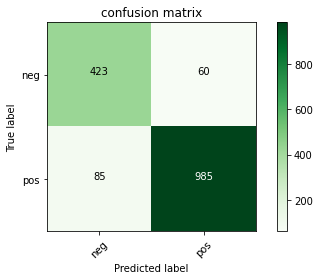

In [12]:
y_true = test.label
print(classification_report(y_true, y_pred_li, target_names=['neg', 'pos']))
cnf_matrix = confusion_matrix(y_true, y_pred_li)
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'],normalize=False,
                    title='confusion matrix')

## Back translate roberta

In [10]:
%%time
translate_roberta =  RoBertaFineTune(False).load_model('./roberta/back_translate_roberta_checkpoint_v3', latest=True)
y_translate_pred_li, y_translate_pred_logitis_li, pooler_translate_out_li, predict_translate_loss = predict(translate_roberta, test)

.....model is loading
You got it
CPU times: user 1min 54s, sys: 929 ms, total: 1min 55s
Wall time: 2min 6s


### predict loss

<AxesSubplot:ylabel='Frequency'>

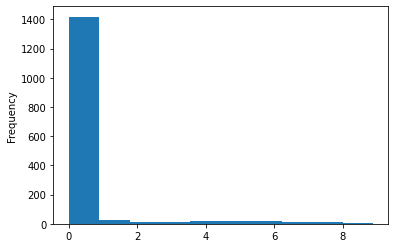

In [11]:
pd.Series([i.numpy() for i in predict_translate_loss]).plot(kind='hist')


              precision    recall  f1-score   support

         neg       0.85      0.88      0.86       483
         pos       0.94      0.93      0.94      1070

    accuracy                           0.91      1553
   macro avg       0.89      0.90      0.90      1553
weighted avg       0.91      0.91      0.91      1553

Confusion matrix, without normalization
[[423  60]
 [ 77 993]]


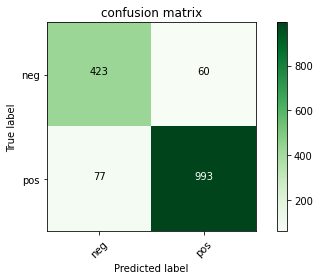

In [11]:
y_true = test.label
print(classification_report(y_true, y_translate_pred_li, target_names=['neg', 'pos']))
cnf_matrix = confusion_matrix(y_true, y_translate_pred_li)
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'],normalize=False,
                    title='confusion matrix')